In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt
import shap

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [4]:
shap.initjs()

In [5]:
# Load data
model_type = "lgb"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2011
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [6]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'
    df_w = cut_to_weekly_data(df_w, 'is_thu')

data compromises 11 years: 410 lines


In [7]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(year_spread=year_spread)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [8]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
    # 'vixo_lag1',
     # 'vixo_lag2',
     # 'vixo_lag3',
     # 'vixo_lag4',
     # 'vixo_lag5',
     # 'vixo_lag6',
     # 'vixo_lag7',
     # 'vixo_lag8',
     # 'vixo_lag9',
     # 'vixo_lag10',
     # 'vixo_lag11',
     # 'vixo_lag12',
     # 'vixo_lag13',
     # 'vixo_lag14',
     # 'vixo_lag15',
     # 'vixo_lag16',
     # 'vixo_lag17',
     # 'vixo_lag18',
     # 'vixo_lag19',
     # 'vixo_lag20',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     # 'ff_M_RF_lag1',
     # 'ff_M_RF_lag2',
     # 'ff_M_RF_lag3',
     # 'ff_M_RF_lag4',
     # 'ff_M_RF_lag5',
     # 'ff_M_RF_lag6',
     # 'ff_M_RF_lag7',
     # 'ff_M_RF_lag8',
     # 'ff_M_RF_lag9',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     'sp_close_lag10',
     'sp_close_lag11',
     'sp_close_lag12',
     'sp_close_lag13',
     'sp_close_lag14',
     'sp_close_lag15'
]

categorical = [    
     'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [9]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# TTS

In [10]:
df_train = df_ws.copy()

In [11]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.2,
                                            add_const=False)

# Sesonality


 Len of complete weeks in X_train: 255


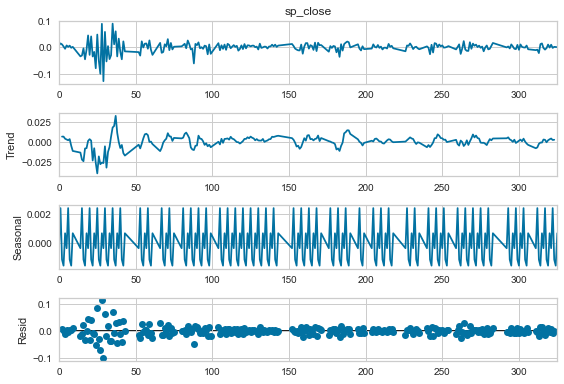

In [12]:
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# create seasonality object
sd = SeasonalTrend(X_train_sea, 'sp_close', 'week', 'weekday', 5, show_fig=True)       
sd.split_time_series()

 # map sesonality to data
if week_day == 'daily': 
    data_dict["model_features"]["weekday_seasonality"] = sd.dict_map_sasonal
    
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [13]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

,VIF,corr_sp_close_lead1
sp_close,118.586502,-0.327435
ff_M_RF,117.748128,-0.314748
sp_close_lag7,1.564232,-0.261894
sp_close_lag5,1.472354,-0.246127
sp_close_lag12,1.479795,-0.200949
sp_close_lag14,1.459497,-0.126418
sp_close_lag9,1.542510,-0.094935
sp_close_lag3,1.505554,-0.074185
sp_close_lag2,1.457651,-0.040883
ff_HML,2.901102,-0.032206


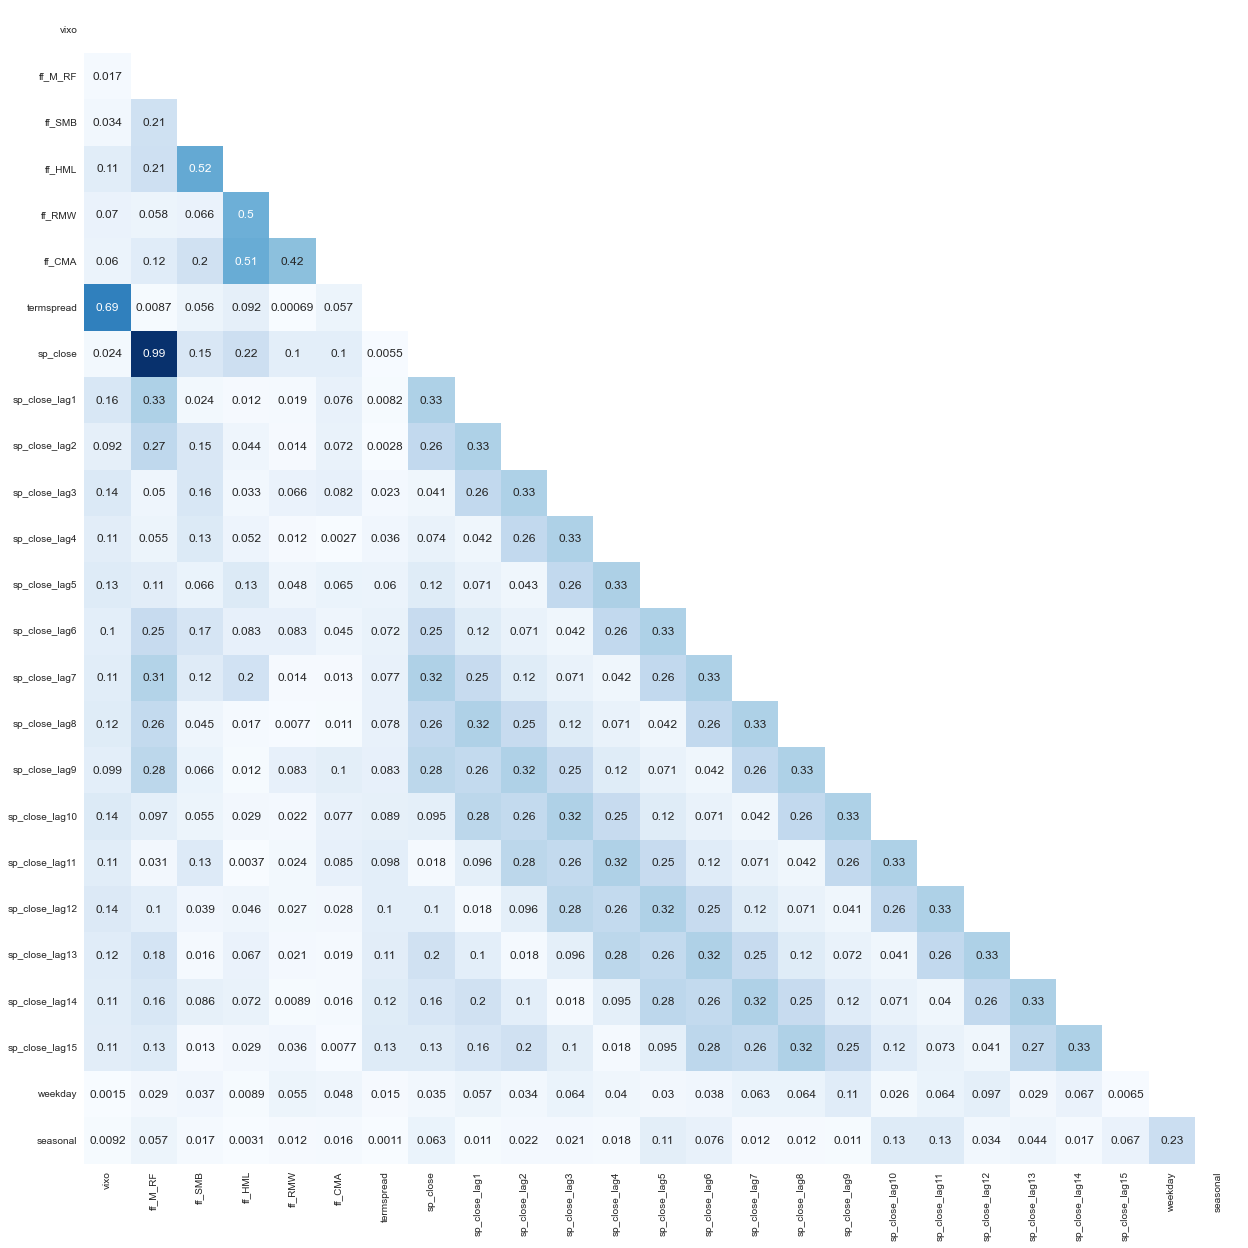

In [14]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

In [15]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

# Standard Scaling

In [16]:
# not required for lgbm

In [17]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_train)
# X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

In [18]:
data_dict["data_transformation"].update(standard_scaling={"scaled_cols": data_dict["model_features"]["predictor"],
                                                          "scaler_x": scaler_x})

# Tuner

In [19]:
tuner_params = {
    'objective': 'regression',
    'metric': ['neg_mean_squared_error', 'l2'],
    'random_state': random_state,
    'categorical_feature': [X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]]
}

tuner_train = lightgbm.Dataset(X_train, y_train, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]])
tuner_eval = lightgbm.Dataset(X_test, y_test, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]], reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 10

In [20]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)])
tuner.run()
t_end = dt.datetime.now()

[I 2022-04-01 17:30:12,165] A new study created in memory with name: no-name-f9c21483-6dde-45d7-b877-a27650ac4a55
[I 2022-04-01 17:30:12,722] Trial 0 finished with value: 4.5448484170493095e-05 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 4.5448484170493095e-05.
[I 2022-04-01 17:30:13,247] Trial 1 finished with value: 4.5448484170493095e-05 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 4.5448484170493095e-05.
[I 2022-04-01 17:30:13,741] Trial 2 finished with value: 4.422710605365683e-05 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 4.422710605365683e-05.
[I 2022-04-01 17:30:14,284] Trial 3 finished with value: 4.422710605365683e-05 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 4.422710605365683e-05.
[I 2022-04-01 17:30:14,842] Trial 4 finished with value: 4.284108218115892e-05 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 4.284108218115892e-05.
[I 2022-04-01 17:

In [21]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

Parameters where tuned for 0:00:42.464823
Max training time was 600


In [22]:
params = tuner.best_params
params = {item: params[item] for item in params.keys() if item != "categorical_feature"}

In [23]:
params

{'objective': 'regression',
 'metric': ['neg_mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.42,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25}

# Model

In [37]:
lgb_wrapper = ExpandingPredictionLGB(model_in=lightgbm,
                           X_train=X_train, 
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                          params=params,
                          categorical_features=data_dict['model_features']['categorical'])

In [38]:
data_dict['model_features'].update(params=lgb_wrapper.params)

# Model eval

In [39]:
%%capture
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=lgb_wrapper,
                          print_results=True)

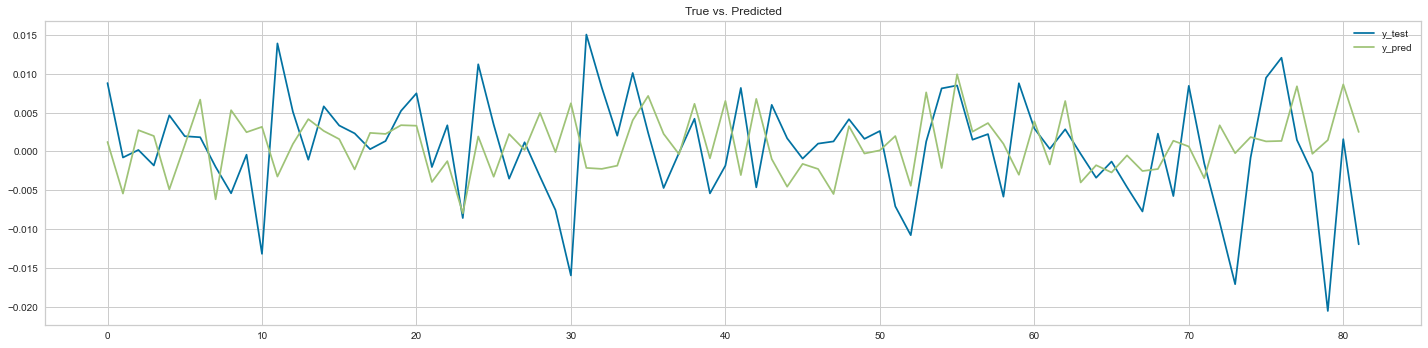

Validation Scores
root mean squared error: 0.0077837937
mean squared error: 6.05874e-05
mean absolute error: 0.0060946432
R2: -0.3411124294


In [40]:
fig_truefit = lgb_eval.get_model_performance()

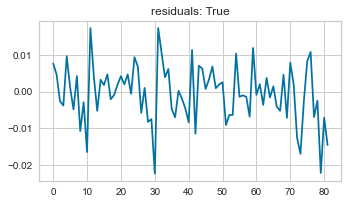

Stationarity Test Results
P-Values: 4.8805221707764475e-14
Test-stats: -8.658986016099258
Time series is stationary: True
Number of lags used: 0




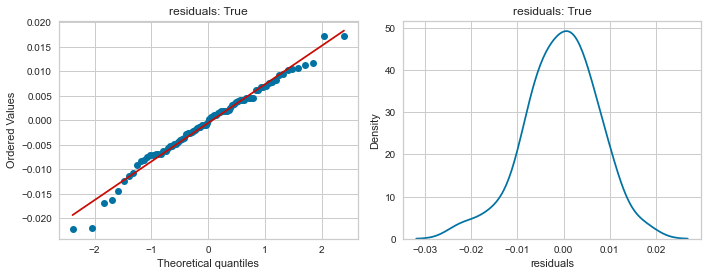

Normality Test Results
P-Values: 0.2060189271647815
Test-stats: 3.1595744699450528
Series is normally distributed: True


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


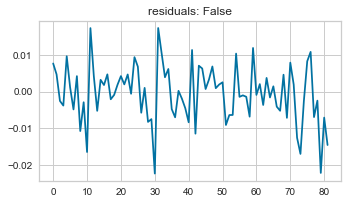

Test for Heteroskedasticity
Test p-value: 0.44804511135535763
Heteroskedasticity is present: False


TTest one sample for mean: 0
Test statistics: -0.6141828606421134
Test pvalue: 0.5408157617281202
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 1.915 < 2.5
First order autocorrlation is not present: : True


In [41]:
stat, norm, hetero, d_watson, zero_mean = lgb_eval.analyse_resids()

In [42]:
lgb_eval.model.params

{'objective': 'regression',
 'metric': ['neg_mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.42,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25}

Using categorical_feature in Dataset.


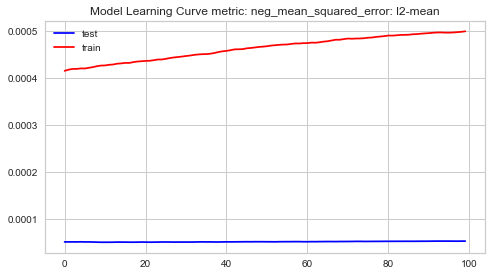

In [43]:
fig_lcurve = lgb_eval.learning_curve("Model Learning Curve")

In [44]:
#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)
data_dict["model_metrics"].update(zeor_mean=zero_mean)

# model performance
data_dict["model_metrics"].update(rmse=lgb_eval.rmse)
data_dict["model_metrics"].update(mse=lgb_eval.mse)
data_dict["model_metrics"].update(mae=lgb_eval.mae)
data_dict["model_metrics"].update(r2=lgb_eval.r2)
data_dict["model_metrics"].update(residuals=lgb_eval.resid_inv)

# Shap values

In [45]:
explainer = shap.TreeExplainer(lgb_eval.model.model)
shap_values = explainer.shap_values(X_test)

In [46]:
idx = 8
print(f'idx {idx} resid values {round(lgb_eval.resid.iloc[idx], 5)}')
print(f'highest resid true value: {round(lgb_eval.y_test.iloc[idx], 5)}')
shap.force_plot(explainer.expected_value, shap_values[idx], X_test.iloc[0,:])

idx 8 resid values -0.0107
highest resid true value: -0.0054


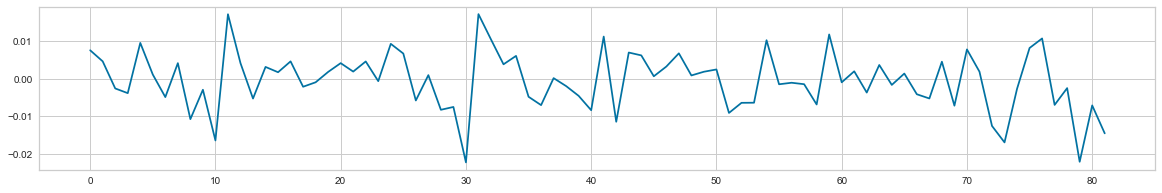

In [47]:
plt.figure(figsize=(20, 3))
plt.plot(lgb_eval.resid);

In [48]:
from_val = 0
to_val = len(X_test)
shap.force_plot(explainer.expected_value, shap_values[from_val : to_val], X_test.iloc[from_val : to_val])

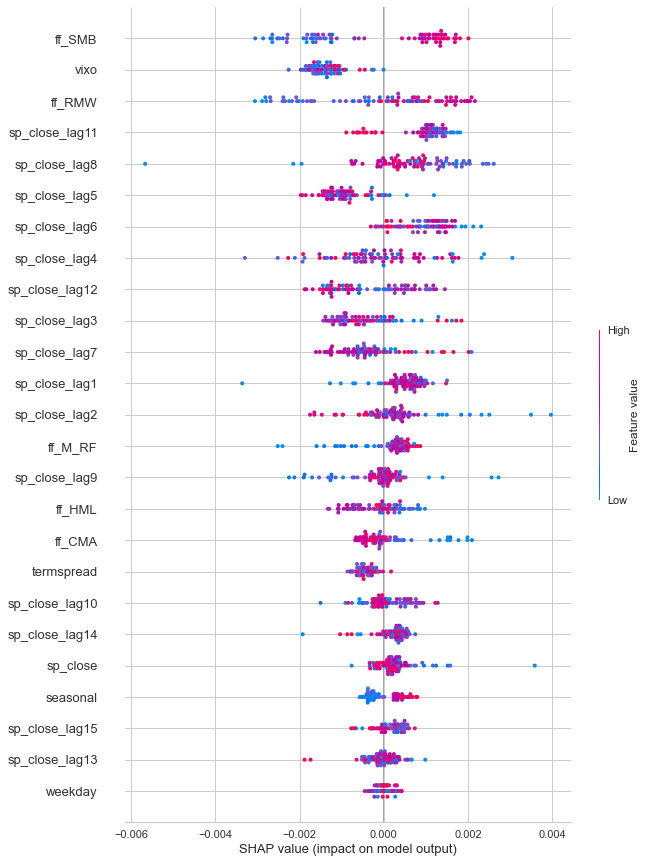

In [50]:
shap.summary_plot(shap_values, X_test, max_display=50, plot_size=(10, 15), show=False)

# Save model

In [51]:
save_model(model=lgb_eval.model.model, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_truefit,
                        fig_lcurve], 
           fig_titles=['fig_truefit', 'fig_lcurve'], model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-04-01_lgb_8055_years2021_2011_sp_close_lead1_sentFalse"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) y
